## Finding Approximate Solutions to the Number Partitioning Problem

Here we demonstrate a potential use-case of the suggested VQA class for QuTiP, in particular, implementing the Quantum Approximate Optimisation Algorithm (QAOA) for use with the `number-partitioning` problem.

### Number Partititioning Problem

`number-partitioning` asks:

Given a set, $S$, of positive integers, is there a partitioning of $S$ into two sets, $S_0$ and $S_1$, such that
$$
\sum S_0 = \sum S_1 \qquad\text{where } S_0 \cup S_1 = S, \qquad S_0 \cap S_1 = \emptyset ?
$$

i.e. two sets with the same sum (or in the optimisation version of the problem, the difference between their sum in minimised).

For example the problem instance $S = [1, 4, 3]$ has two solutions:

$$
S_0 = [1, 3],~S_1 = [4] \qquad S_0 = [4],~S_1 = [1, 3].
$$

### QAOA

Here we will skip to the result of [the QAOA algorithm](https://arxiv.org/abs/1411.4028).

\begin{align}
U(\beta, \gamma) = \prod_{j=0}^p e^{-\beta_j H_B}e^{-i\gamma_j H_P} 
\end{align}

Where $U(\beta, \gamma)$ is the unitary which can be implemented by some quantum circuit in which
- $p$ is the number of "layers".
- $\beta$ and $\gamma$ are both lists of $p$ free parameters, updated by the classical optimiser. 
- $H_P$ is the "problem Hamiltonian", in this case whose ground state encodes the solution to a number partitioning instance (more on this shortly).
- $H_B$ is a mixing Hamiltonian, which should not commute with $H_P$.

In [1]:
# Imports
import numpy as np
from qutip import Qobj, tensor
from qutip_qip.operations import z_gate, x_gate, snot
from qutip_qip.vqa import VQA, VQABlock # new module!

## Defining a Problem Hamiltonian

Based on our problem structure, we may know how to encode our problem into a Hamiltonian. For many NP complete problems, [this paper](https://arxiv.org/abs/1302.5843) gives Ising formulations, which, usually, can easily translate to Hamiltonians.

For the Number Partitioning problem, we want our Hamiltonian to encode the fact that there is an energy cost associated with the difference between the sum of the two sets. Therefore, we could assign a positive +1 weight to all the elements of one set, and a -1 weight to all elements of the other and take our cost as the sum over S with these weights applied. 

For any proposed solution to a problem instance $S$, where $S$ contains $N$, elements, we give a list, $W$, of $N$ of these weights ($w_0, w_1, \dots w_{N-1}$), corresponding to the partitioning of the elements of $S$. 

Returning to our example before, we had $S = [1, 4, 3]$. One solution would be to choose $W = [1, -1, 1]$.

It should be clear then that the cost of any solution is given by

$$
C(S, W) = \left(\sum_{i=0}^{N-1} w_i s_i\right)^2
$$

We can write our problem Hamiltonian as

\begin{align}
H_P = \left(\sum_{i=0}^{N-1} \sigma^{(i)}_z s_i \right)^2
\end{align}

Where $\sigma_z$ is the Pauli $Z$ operator, and the superscript denotes that it operates on the *i*-th qubit.

In [2]:
# Implementing H_P in QuTiP
def H_P(S):
    """
    Parameters
    ----------
    S : list of int
        Problem instance array, containing positive integers
    
    Returns
    -------
    H_P : Qobj
        Problem Hamiltonian corresponding to problem instance
    """
    zeros = Qobj(np.zeros([2, 2]))
    # Construct zero matrix Qobj
    H = zeros
    for i in range(len(S) - 1):
        H = tensor(H, zeros)
    # Weight each element of S by pauli Z operator (as in eqn (2))
    for i, s in enumerate(S):
        H += s * z_gate(N=len(S), target=i)
    return pow(H, 2)
"""
The form of the mixing Hamiltonian is more free. In this case
we use a pauli X operator on each qubit for simplicity.
"""
# Mixing Hamiltonian
def H_B(S):
    zeros = Qobj(np.zeros([2, 2]))
    H = zeros
    for i in range(len(S) - 1):
        H = tensor(H, zeros)
    for i, s in enumerate(S):
        H += x_gate(N=len(S), target=i)
    return H

## Simulating in QuTiP

After specifying our Hamiltonians, all that's left to do is initialise an instance of the VQA class, set up our circuit in the form of eqn (1), and hit optimise.

/home/ben/.conda/envs/qutip-dev/lib/python3.9/site-packages/qutip/qip/circuit.py:274: UserWarning: Unknown gate H_P
  warnings.warn("Unknown gate %s" % name)
/home/ben/.conda/envs/qutip-dev/lib/python3.9/site-packages/qutip/qip/circuit.py:274: UserWarning: Unknown gate H_B
  warnings.warn("Unknown gate %s" % name)


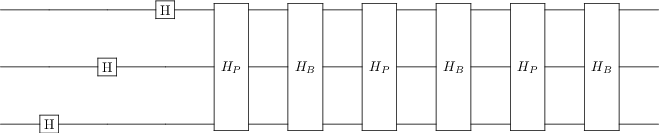

In [3]:
S = [1, 3, 4] # Problem instance

n_qubits = len(S) # Need one qubit for each element of S

VQA_circuit = VQA(
    n_qubits = n_qubits,
    n_layers = 3,
    cost_method = "OBSERVABLE"
)

# Define blocks holding our problem and mixing hamiltonian
H_P_Block = VQABlock(H_P(S), name="H_P")
H_B_Block = VQABlock(H_B(S), name="H_B")

# Generate initial circuit state by applying Hadamards to every qubit
for i in range(n_qubits):
    VQA_circuit.add_block(
        VQABlock("SNOT", targets=[i], initial=True)
        )
# Add in our layered blocks
VQA_circuit.add_block(H_P_Block)
VQA_circuit.add_block(H_B_Block)

# Set cost function to be expectation value of H_P
VQA_circuit.cost_observable = H_P(S)

# Visualising the circuit
free_params = VQA_circuit.get_free_parameters()
# construct circuit instance with dummy (0) parameters
VQA_circuit.construct_circuit([0 for i in range(free_params)])

Optimization Result:
	Minimum cost: 0.4091760727351272
	Number of function evaluations: 346
	Parameters found: [0.96389037 0.90890789 1.57313656 1.3076372  1.215386   1.19829767]


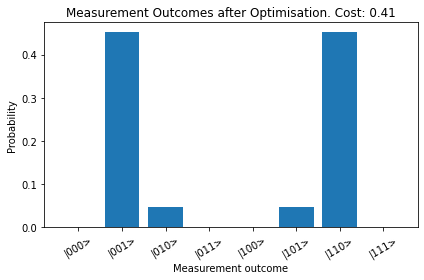

In [5]:
result = VQA_circuit.optimize_parameters()
print(result)
result.plot(S)

Optimization Result:
	Minimum cost: 0.052938222829627804
	Number of function evaluations: 63
	Parameters found: [ 0.62410984 -0.68771451  1.09968346 -0.22319068  0.75248871  1.21041769]


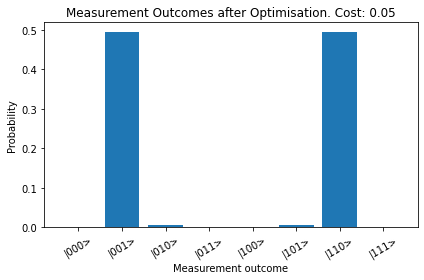

In [6]:
"""
We can also specify more complicated rules for optimization. 
For example, here we specify a gradient-based method (BFGS),
and tell the optimizer to compute a jacobian at each step to
feed into the BFGS algorithm. 
"""
result = VQA_circuit.optimize_parameters(
    method="BFGS", use_jac=True, 
    initial="random", layer_by_layer=False
)
print(result)
result.plot(S)

In [7]:
print(result.final_state)

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.00032149-0.00317329j]
 [ 0.31101793+0.63014012j]
 [-0.0624785 +0.04736425j]
 [ 0.0056248 -0.00159262j]
 [ 0.0056248 -0.00159262j]
 [-0.0624785 +0.04736425j]
 [ 0.31101793+0.63014012j]
 [ 0.00032149-0.00317329j]]
